# Introduction to the ice fitting workshop - 15/October/2024

### Continuum determination (Polynomial approach)

Continuum is the "baseline" in the spectral energy distribution of a protostar, i.e., the profile that lies just above absorption bands or just below emission features. Two methods are introduced here in this part of the tutorial:

1) Polynomial function - A low order polynomial is used to trace the continuum curve within a specific range.

2) Blackbody combination - One or more blackbody functions are linearly combined to fit/extract the protostellar continuum spectrum.

*These two methods have advantages and disadvantages, which will be discussed in the live demonstration.*

### Polynomial function

A polynomial function given below is used to determine the continuum SED in the protostellar spectrum.

$F_{\rm{poly}} = \sum_{k=0}^{n} a_k \lambda_k$,

where $\lambda$ is the wavelength and $a_k$ is the coefficient for each term $k$.

To determine the continuum SED using ENIIGMA, you can use the function **Fit.Continuum_Poly**. The input information used by this function are:

1) filename: the path to the file containing the protostar spectrum in Jy units;

2) the full range where the continuum SED will be calculated;

3) the polynomial order to perform the fit;

4) the specific ranges to fit the protostar spectrum. Useful to skip regions with absorption or emission profiles.

An example of the **Fit.Continuum_Poly** is given below. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import os
#%matplotlib inline
%matplotlib notebook

In [2]:
#======= nature constants (seem global) =====================
cl      = 2.99792458E+08  # speed of light [m/s]
hplanck = 6.62607554E-34  # Planck's constant [J s]
bk      = 1.38065812E-23  # Boltzmann's constant [J/K]
pi      = np.pi           # just pi
dir = os.getcwd()

In [3]:
def find_nearest(array, value):
    """
    Find nearest value of a given number.

    Parameters
    -------------

    array : 'numpy.ndarray'
        Vector with the value of interest.

    value : 'float'
        Value of interest.

    Returns
    -------------
    Nearest value

    """

    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_line_number2(value, matrix):
    """
    Function used to get the line number of a value in a array.

    Parameters
    -------------

    value : 'float'
        Value of interest.

    matrix : 'numpy.ndarray'
        Vector with the value of interest.

    Returns
    ------------

    Index

    """

    for i, line in enumerate(matrix, 1):
        if line == value:
            return i

In [4]:
def Continuum_poly(filename, xmin, xmax, order=2, range_limits=None):
    """
    Calculates the continuum of the Spectral Energy Distribution (SED) using the polynomial fitting.

    Parameters
    -------------

    filename : 'str'
        Three columns file containing the wavelength in units of micrometers, the flux in units of Jansky and the flux error.

    xmin, xmax : 'float'
        Intervals used to calculate the continuum in units of micrometers.

    order : 'float'
        Polynomial order.

    range_limits : 'numpy.ndarray'
        Ranges adopted for the continuum in units of micrometers. E.g. [[2.,3.], [8.,9]]. The funtion will take only these intervals to perform the fit.
        The rest of the spectrum will be masked.
        Default: None

    Returns
    -------------
    ASCII files

    Flux_filename.flux (units of W cm-2)

    Poly_Cont_filename.cont (units of W cm-2)

    Optical_depth_filename.od

    Continuum_filename.pdf

    """

    #======================================================================
    print('Determining the continuum...')
    #=================Input Parameters ====================================

    files = glob.glob(filename)

    count = 0
    fig = plt.figure()
    i = len(files)

    for index in range(i):
        name = files[index].rsplit('/', 1)[1]
        t = np.loadtxt(files[index],skiprows=1).T
        x_lam = t[0]
        x_nu = cl/(x_lam*1e-6)
        y = t[1]
        ey = t[2]
        y2 = x_nu*y*1e-30
        ey2 = x_nu*ey*1e-30
        ratio = ey2/y2

        range_limits = range_limits

        if range_limits != None:
            xrange1t = []
            yrange1t = []
            for i in range(len(range_limits)):
                id_n = []
                for j in range(2):
                    frg_lam1 = range_limits[i][j]
                    rg1 = find_nearest(x_lam, frg_lam1) #find number nearby
                    id_n.append(get_line_number2(rg1, x_lam))
                xrange1t.append(x_lam[id_n[0]:id_n[1]])
                yrange1t.append(y2[id_n[0]:id_n[1]])

            xrange1t2 = []
            yrange1t2 = []
            for i in range(len(xrange1t)):
                for j in range(len(xrange1t[i])):
                    xrange1t2.append(xrange1t[i][j])
                    yrange1t2.append(yrange1t[i][j])
        else:
            xrange1t2, yrange1t2 = x_lam, y2


        np.savetxt('Flux_'+name.split('.')[0]+'.flux', np.transpose([x_lam, y2])) #Save the flux in W cm-2 s-1

        lam1, lam2 = xmin, xmax
        pp1 = find_nearest(x_lam, lam1)
        pp2 = find_nearest(x_lam, lam2)
        npoints = len(x_lam)
        tt = np.linspace(pp1, pp2, npoints)


        Fcont = np.poly1d(np.polyfit(xrange1t2, yrange1t2, order)) #polynomial fitting
        np.savetxt('Poly_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, Fcont(tt)]))

        try:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        except ValueError:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        tau_poly = -1*np.log(Fdata(tt)/Fcont(tt))
        etau = etau0(tt)
        np.savetxt('Optical_depth_'+name.split('.')[0]+'.od', np.transpose([tt,tau_poly,etau]))

        x_filt_b = x_lam[x_lam <= 2.5]
        y_filt_b = y2[x_lam <= 2.5]
        ey_filt_b = ratio[x_lam <= 2.5]

        x_filt_a = x_lam[x_lam > 2.5]
        y_filt_a = y2[x_lam > 2.5]

        sub1=fig.add_subplot(211)
        sub1.plot(x_filt_a, -1*np.log10(y_filt_a), color='black', label='Observed data')
        sub1.errorbar(x_filt_b, -1*np.log10(y_filt_b), yerr=0.434*ey_filt_b, marker='s', color='grey', linestyle='None')
        sub1.plot(tt, -1*np.log10(Fcont(tt)), ':', color='b', label='Continuum (Polynomial)')
        sub1.minorticks_on()
        sub1.tick_params(which='major', direction='in', labelsize=10)
        sub1.tick_params(which='minor', direction='in', labelsize=10)

        ymin = min(-1*np.log10(y2)) - 0.005*min(-1*np.log10(y2))
        ymax = max(-1*np.log10(y2)) + 0.005*max(-1*np.log10(y2))

        plt.ylim(ymax, ymin)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'$\mathrm{-log(Flux[W cm^{-2}])}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)
        try:
            taumax = max(tau_poly) + 0.1*max(tau_poly)
        except ValueError:
            taumax = 5.


        ground = tau_poly*0

        sub2=fig.add_subplot(212)
        sub2.plot(tt, tau_poly, label=None)
        sub2.plot(tt, ground, ':')
        sub2.minorticks_on()
        sub2.tick_params(which='major', direction='in', labelsize=10)
        sub2.tick_params(which='minor', direction='in', labelsize=10)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
        try:
            plt.ylim(taumax,-0.2)
        except ValueError:
            plt.ylim(5.,-0.2)
        plt.tight_layout()
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)

        count = count+1

    #plt.show()
    plt.savefig('Continuum_'+name.split('.')[0]+'.pdf',format='pdf', bbox_inches='tight', dpi=300)

In [20]:
def Continuum_poly_ref_points(filename, filename_ref='ref_points_av60.dat', order=2):
    """
    Calculates the continuum of the Spectral Energy Distribution (SED) using the polynomial fitting.

    Parameters
    -------------

    filename : 'str'
        Three columns file containing the wavelength in units of micrometers, the flux in units of Jansky and the flux error.

    xmin, xmax : 'float'
        Intervals used to calculate the continuum in units of micrometers.

    order : 'float'
        Polynomial order.

    range_limits : 'numpy.ndarray'
        Ranges adopted for the continuum in units of micrometers. E.g. [[2.,3.], [8.,9]]. The funtion will take only these intervals to perform the fit.
        The rest of the spectrum will be masked.
        Default: None

    Returns
    -------------
    ASCII files

    Flux_filename.flux (units of W cm-2)

    Poly_Cont_filename.cont (units of W cm-2)

    Optical_depth_filename.od

    Continuum_filename.pdf

    """

    #======================================================================
    print('Determining the continuum...')
    #=================Input Parameters ====================================

    files = glob.glob(filename)

    count = 0
    fig = plt.figure()
    i = len(files)

    for index in range(i):
        name = files[index].rsplit('/', 1)[1]
        t = np.loadtxt(files[index],skiprows=1).T
        x_lam = t[0]
        x_nu = cl/(x_lam*1e-6)
        y = t[1]
        ey = t[2]
        y2 = x_nu*y*1e-30
        ey2 = x_nu*ey*1e-30
        ratio = ey2/y2
        
        name_ref = filename_ref
        tref = np.loadtxt(name_ref).T
        x_lam_ref = tref[0]
        y_ref = tref[1]


        np.savetxt('Flux_'+name.split('.')[0]+'.flux', np.transpose([x_lam, y2])) #Save the flux in W cm-2 s-1
        
        Fcont = np.poly1d(np.polyfit(x_lam_ref, y_ref, order)) #polynomial fitting
        
        lam1, lam2 = x_lam_ref[0], x_lam_ref[len(x_lam_ref)-1]
        npoints = len(x_lam)
        tt = np.linspace(lam1, lam2, len(x_lam))
        
        np.savetxt('Poly_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, Fcont(tt)]))


        try:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        except ValueError:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        tau_poly = -1*np.log(Fdata(tt)/Fcont(tt))
        etau = etau0(tt)
        np.savetxt('Optical_depth_'+name.split('.')[0]+'.od', np.transpose([tt,tau_poly,etau]))

        x_filt_b = x_lam[x_lam <= 2.5]
        y_filt_b = y2[x_lam <= 2.5]
        ey_filt_b = ratio[x_lam <= 2.5]

        x_filt_a = x_lam[x_lam > 2.5]
        y_filt_a = y2[x_lam > 2.5]

        sub1=fig.add_subplot(211)
        sub1.plot(x_filt_a, -1*np.log10(y_filt_a), color='black', label='Observed data')
        sub1.errorbar(x_filt_b, -1*np.log10(y_filt_b), yerr=0.434*ey_filt_b, marker='s', color='grey', linestyle='None')
        sub1.plot(tt, -1*np.log10(Fcont(tt)), ':', color='b', label='Continuum (Polynomial)')
        sub1.plot(x_lam_ref, -1*np.log10(y_ref), 'o')
        sub1.minorticks_on()
        sub1.tick_params(which='major', direction='in', labelsize=10)
        sub1.tick_params(which='minor', direction='in', labelsize=10)

        ymin = min(-1*np.log10(y2)) - 0.005*min(-1*np.log10(y2))
        ymax = max(-1*np.log10(y2)) + 0.005*max(-1*np.log10(y2))

        plt.ylim(ymax, ymin)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'$\mathrm{-log(Flux[W cm^{-2}])}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)
        try:
            taumax = max(tau_poly) + 0.1*max(tau_poly)
        except ValueError:
            taumax = 5.


        ground = tau_poly*0

        sub2=fig.add_subplot(212)
        sub2.plot(tt, tau_poly, label=None)
        sub2.plot(tt, ground, ':')
        sub2.minorticks_on()
        sub2.tick_params(which='major', direction='in', labelsize=10)
        sub2.tick_params(which='minor', direction='in', labelsize=10)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
        try:
            plt.ylim(taumax,-0.2)
        except ValueError:
            plt.ylim(5.,-0.2)
        plt.tight_layout()
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)

        count = count+1

    #plt.show()
    plt.savefig('Continuum_'+name.split('.')[0]+'.pdf',format='pdf', bbox_inches='tight', dpi=300)

### Example:  Ice Age source - NIR 38 (AV60); Fitting from 2.5 to 13 $\mu$m

JWST spectrum of NIR38. Combination based on NIRSpec FS, NIRCam WFSS and MIRI LRS FS data available at https://zenodo.org/record/7501239.

Published in McClure et al. (2023), Nature Astronomy.
Full observational and data reduction details given 
in the Methods section of that publication.


A few relevant papers (focused on ices): 

- Boogert et al. (2000): https://articles.adsabs.harvard.edu/pdf/2000A%26A...360..683B
- Boogert et al. (2002): https://iopscience.iop.org/article/10.1086/339627/pdf
- Dartois et al. (2002): https://www.aanda.org/articles/aa/pdf/2002/42/aa2737.pdf
- Gibb et al. (2004): https://iopscience.iop.org/article/10.1086/381182/pdf
- Boogert et al. (2008): https://iopscience.iop.org/article/10.1086/533425/pdf
- Rocha & Pilling (2015): https://iopscience.iop.org/article/10.1088/0004-637X/803/1/18/pdf
- Rocha & Pilling (2018): https://academic.oup.com/mnras/article/478/4/5190/5046193
- Boogert et al. (2015): https://www.annualreviews.org/doi/abs/10.1146/annurev-astro-082214-122348
- McClure et al. (2023): https://www.nature.com/articles/s41550-022-01875-w

Determining the continuum...


<IPython.core.display.Javascript object>


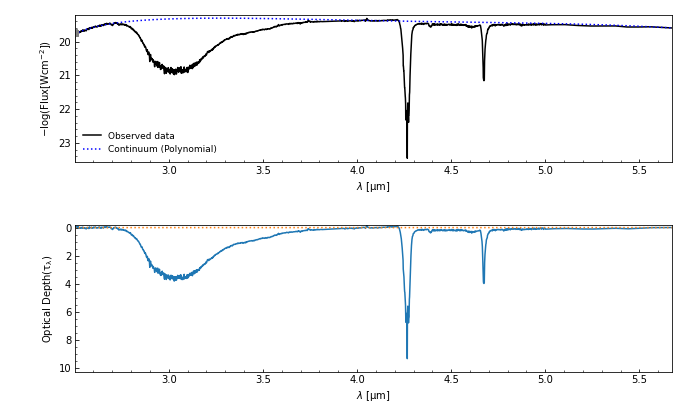

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [8]:
filename = dir+'/'+'NIR38JWST.txt'
Continuum_poly(filename, 2.5, 5.7, order = 5., range_limits=[[2.5, 2.7], [4.0, 4.1], [5.5, 5.7]])

##Ice Age settings
##Continuum_poly(filename, 2.4, 6.0, order = 5., range_limits=[[2.4, 2.49], [2.65, 2.69], [2.715, 2.72], [4.0, 4.04], [4.06, 4.07, 5.15, 5.2], [5.3, 5.7]])

### Exercise: Continuum on the MIRI range (5 - 13 $\mu$m)

Determining the continuum...


<IPython.core.display.Javascript object>


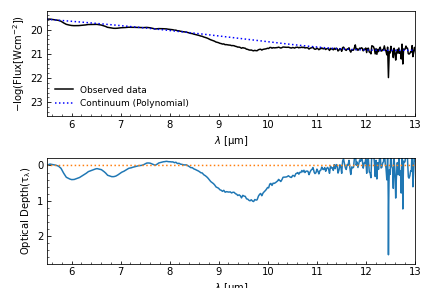

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [9]:
filename = dir+'/'+'NIR38JWST.txt'
Continuum_poly(filename, 5.5, 13., order = 3., range_limits=[[5.0, 5.5], [12.7, 13.0]]) ## XXX: your inputs

Determining the continuum...


<IPython.core.display.Javascript object>


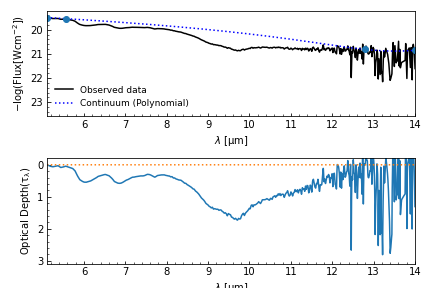

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [21]:
filename = dir+'/'+'NIR38JWST.txt'
Continuum_poly_ref_points(filename, filename_ref='ref_points_av60.dat', order = 2) ## XXX: your inputs